In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [20]:
cd ..

/disk/users/hutmache/Projekte


In [21]:
from data import sample_generators

- 50,50 Layers and learning rate of 0.001 works

# Model Building

In [22]:
sigma_max = 5


#x[0] = 1e-6
x, y = sample_generators.generate_osband_sin_samples(size=60)
#x, y = sample_generators.generate_osband_nonlinear_samples()
assert len(x) == len(y)

x = x.astype(np.float64)
y = y.astype(np.float64)

# TODO add initializer
x_data = tf.placeholder(tf.float64, [None, 1])
y_data = tf.placeholder(tf.float64, [None, 1])

    def mixture_density_network(x, n_mixtures):
    with tf.device("/gpu:0"):

        #x = tf.reshape(x, [-1, 1])
        fc1 = tf.layers.dense(inputs=x, units=15, activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1, units=15, activation=tf.nn.relu)

        # Output units K*3 elements
        output_layer = tf.layers.dense(inputs=fc2, units=n_mixtures*3)
        raw_output = tf.reshape(output_layer, [-1, n_mixtures, 3])
        
        mixture_weights = tf.nn.softmax(raw_output[:, :, 0] - 
                                        tf.expand_dims(tf.reduce_max(raw_output[:, :, 0], axis=1), 1))
        #mixture_weights = tf.nn.softmax(raw_output[:, :, 0] - tf.reduce_max(raw_output[:, :, 0]))
        #mixture_weights = tf.nn.softmax(raw_output[:, :, 0])
        #mixture_weights = (tf.exp(raw_output[:, :, 0] - tf.expand_dims(tf.reduce_max(raw_output[:, :, 0], axis=1), 1)) \
        mixture_means = raw_output[:, :, 1]
        mixture_variances = sigma_max * tf.sigmoid(raw_output[:, :, 2])
        
        return mixture_weights, mixture_means, mixture_variances 



Epoch 0
Loss 1.92538701937


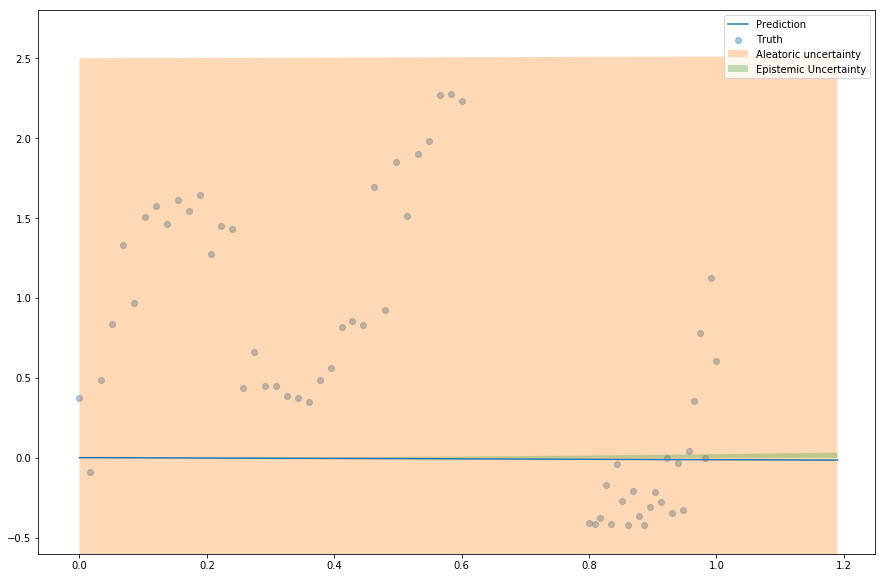

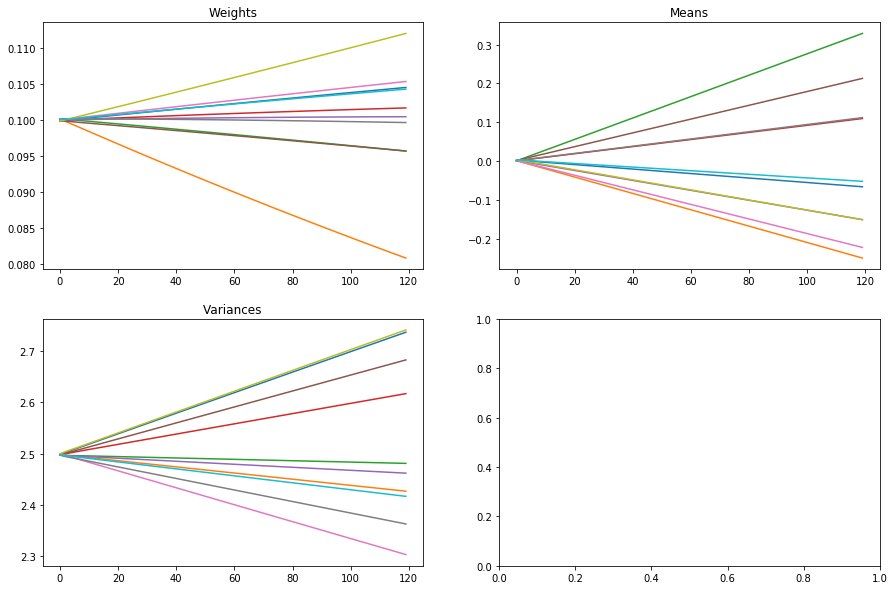

Epoch 2000
Loss 0.200465407637


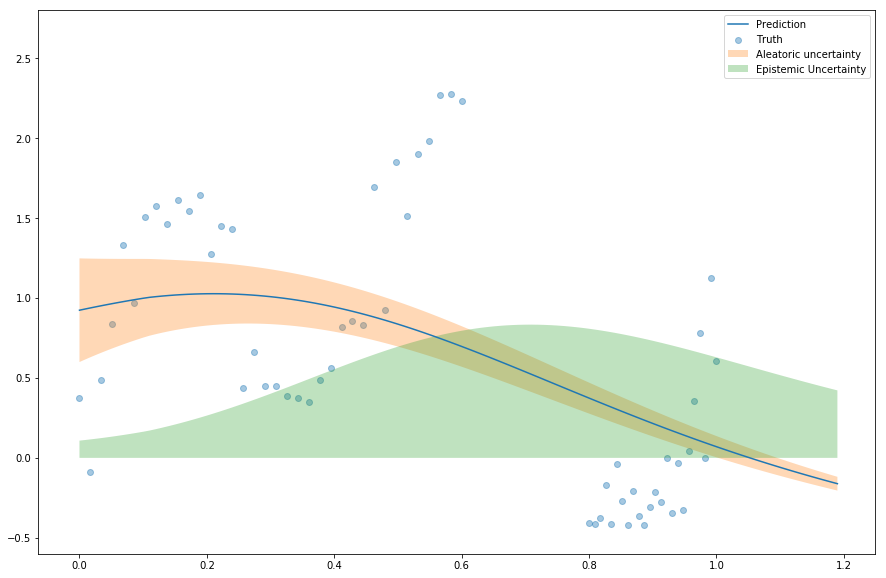

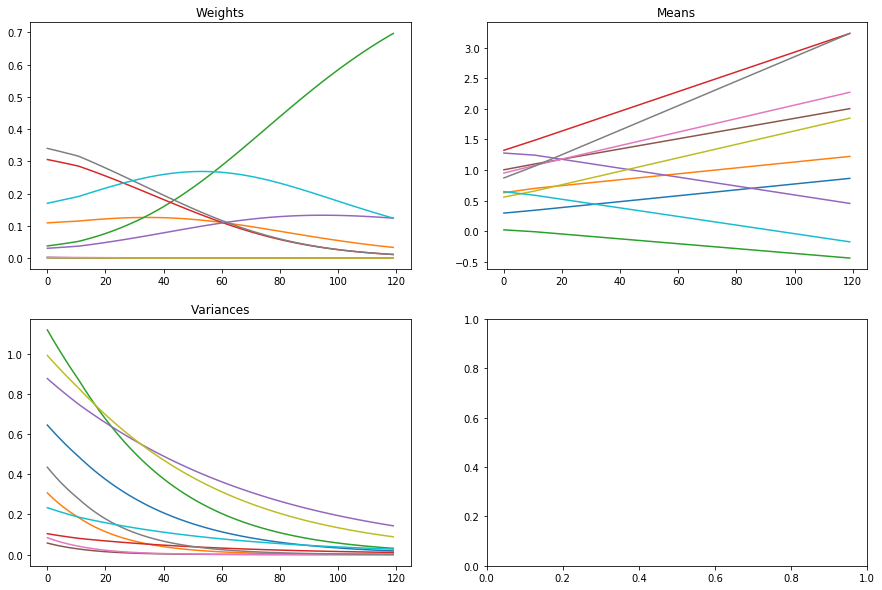

Epoch 4000
Loss 0.140789945108


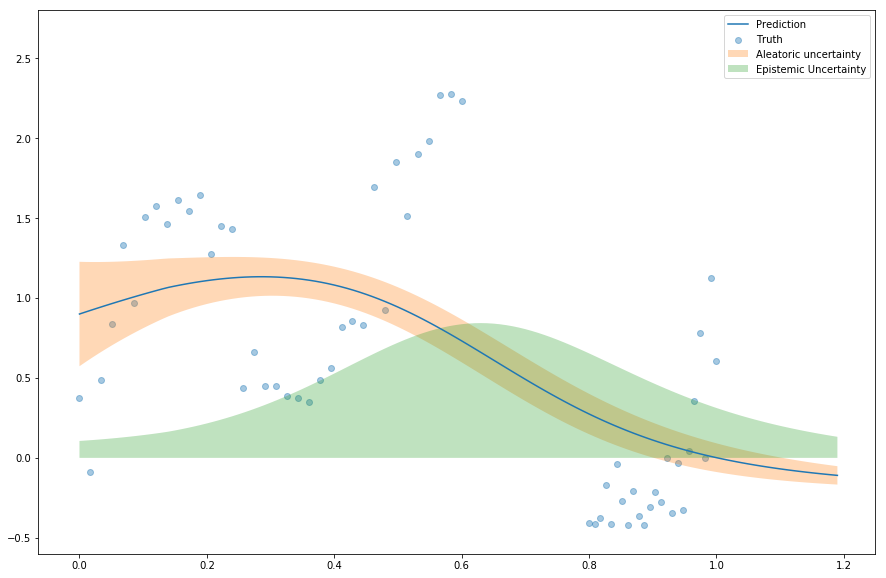

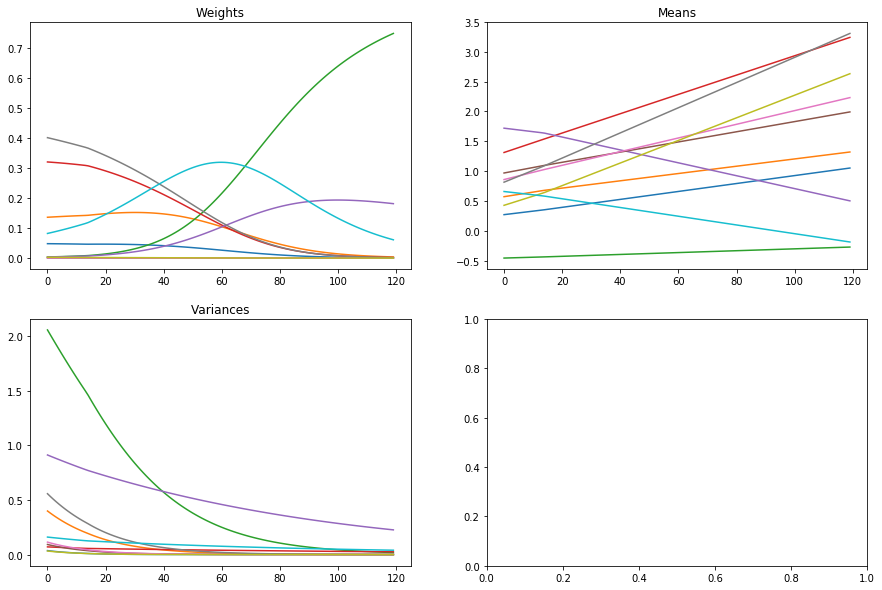

Epoch 6000
Loss 0.120116755687


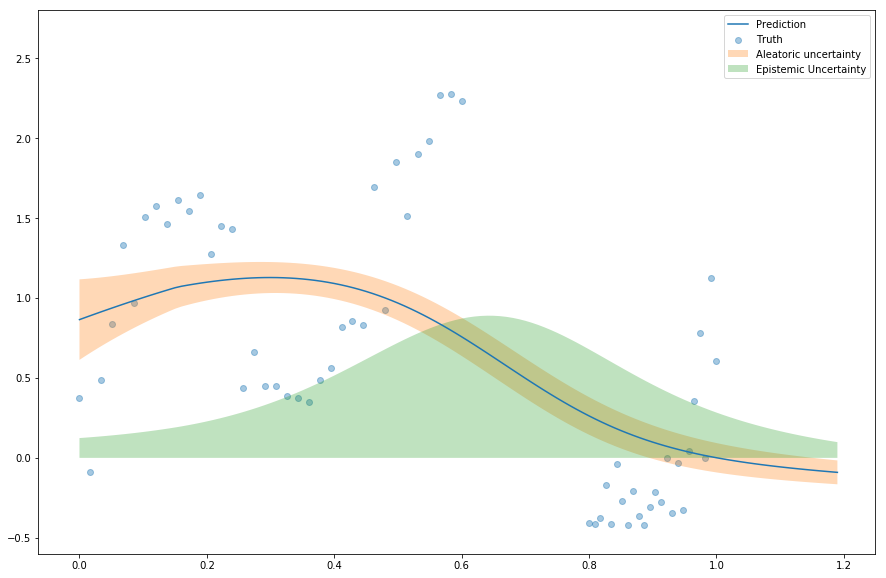

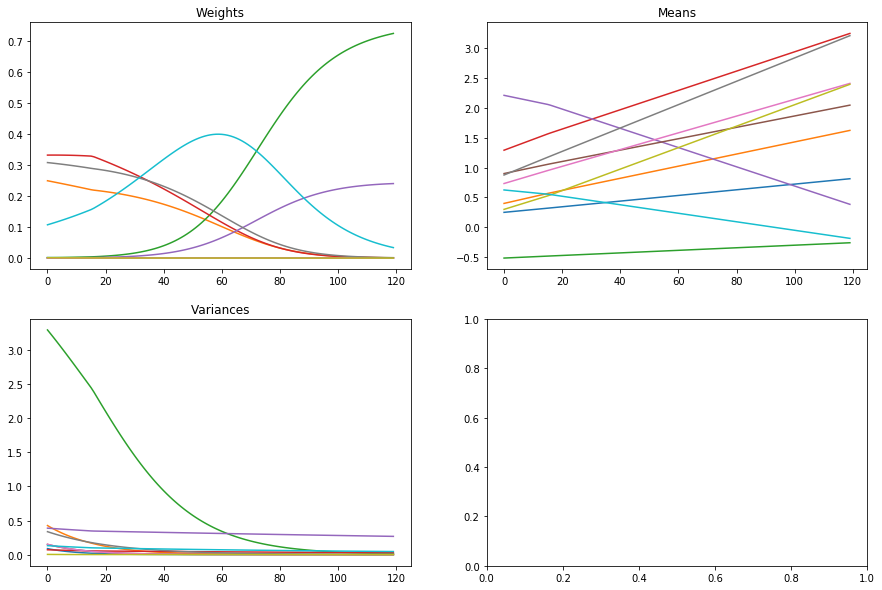

Epoch 8000
Loss -0.108114012633


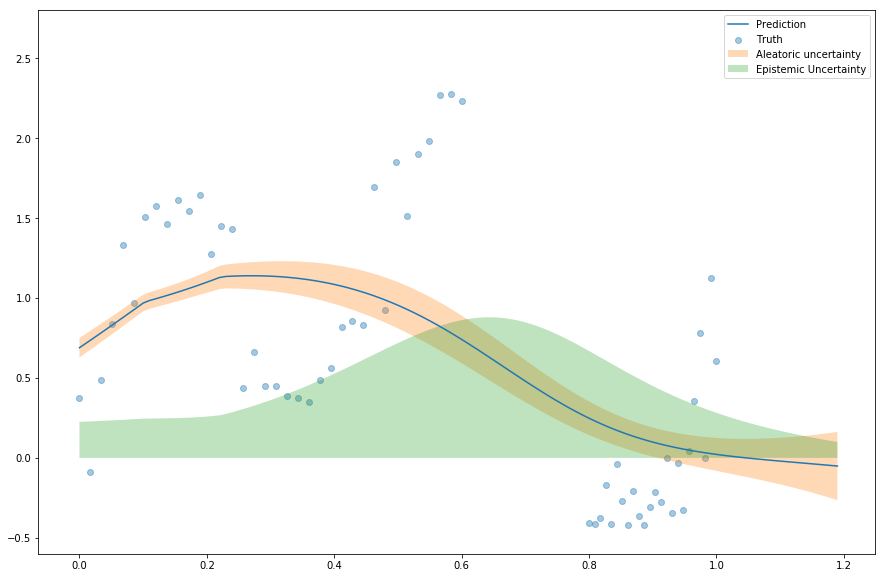

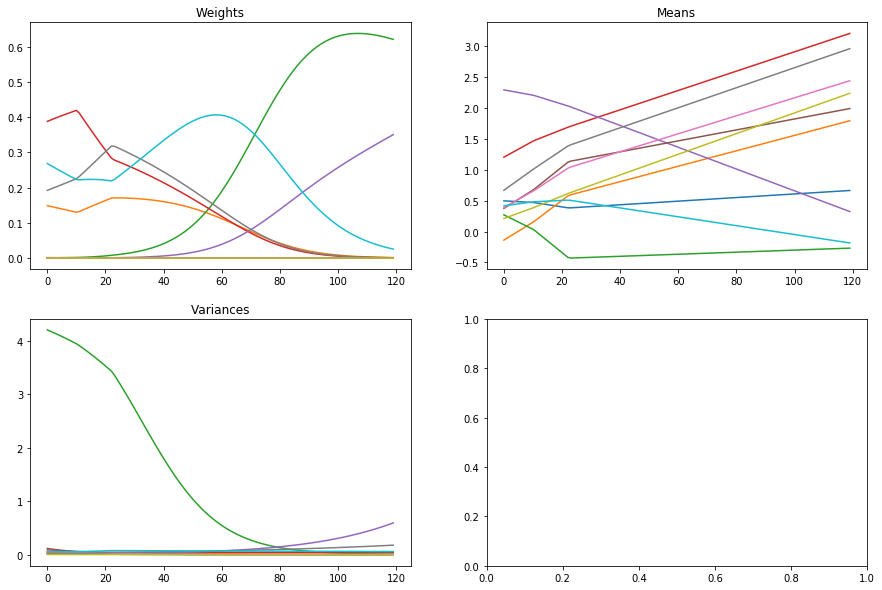

Epoch 10000
Loss -0.267877057532


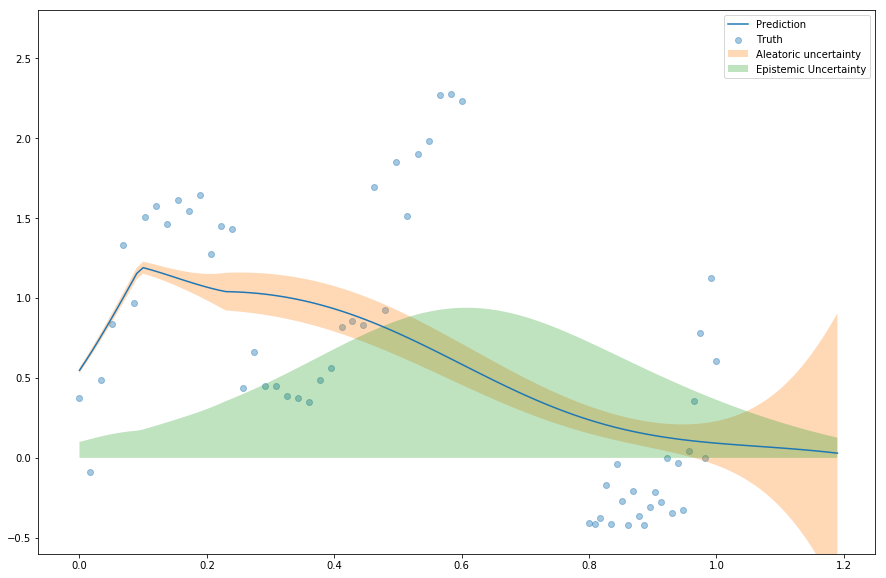

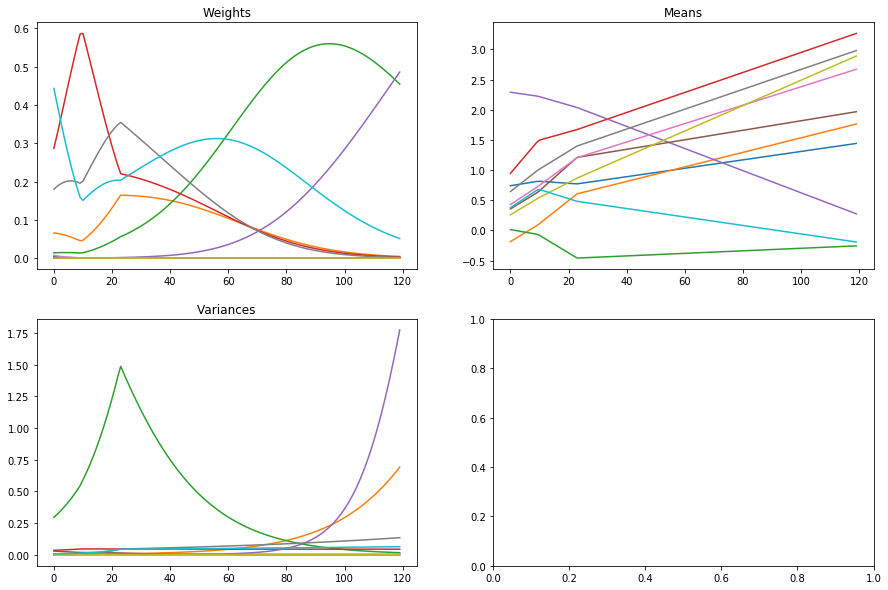

Epoch 12000
Loss 0.079404497574


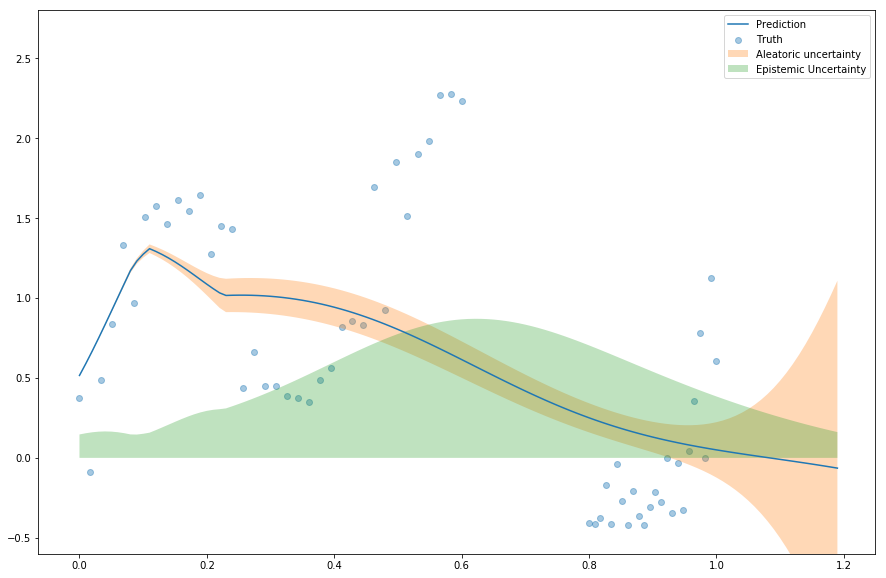

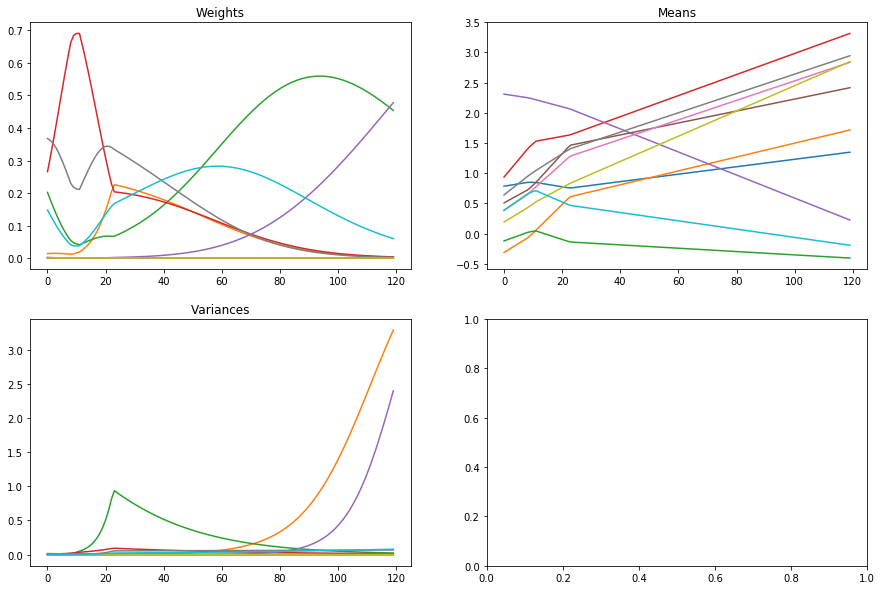

Epoch 14000
Loss 0.51552293596


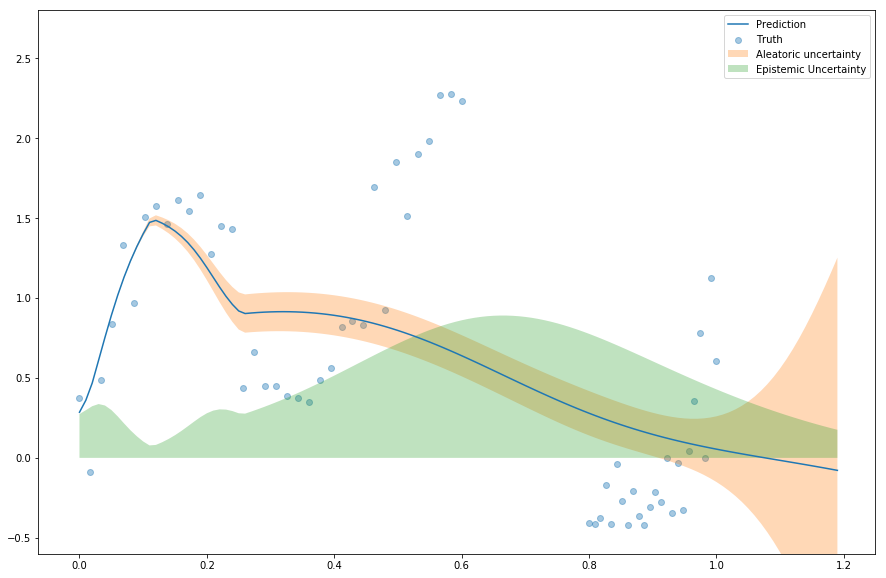

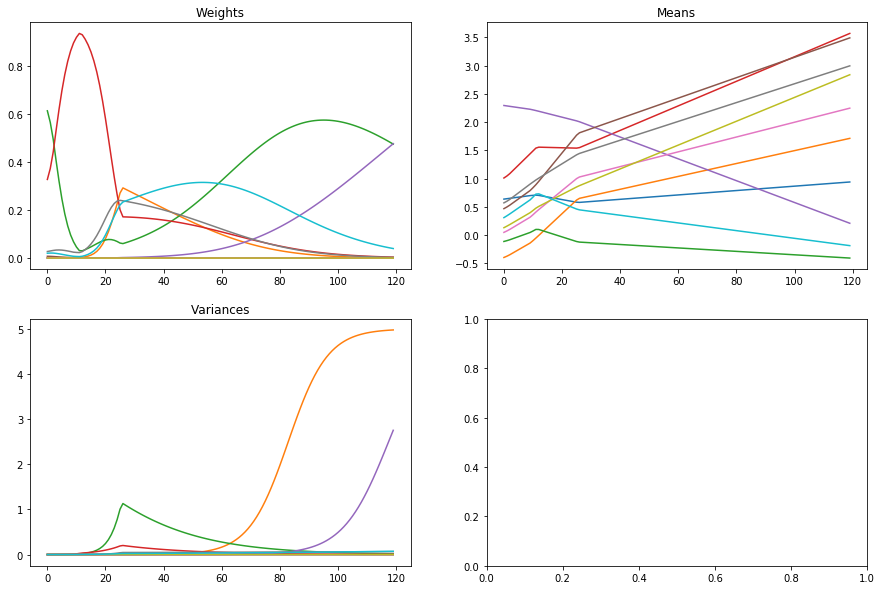

Epoch 16000
Loss 0.824251242618


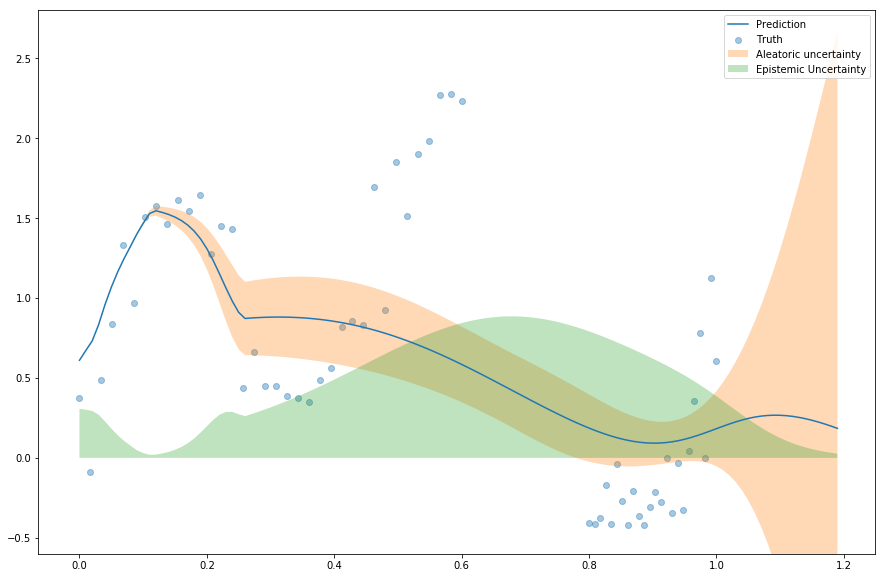

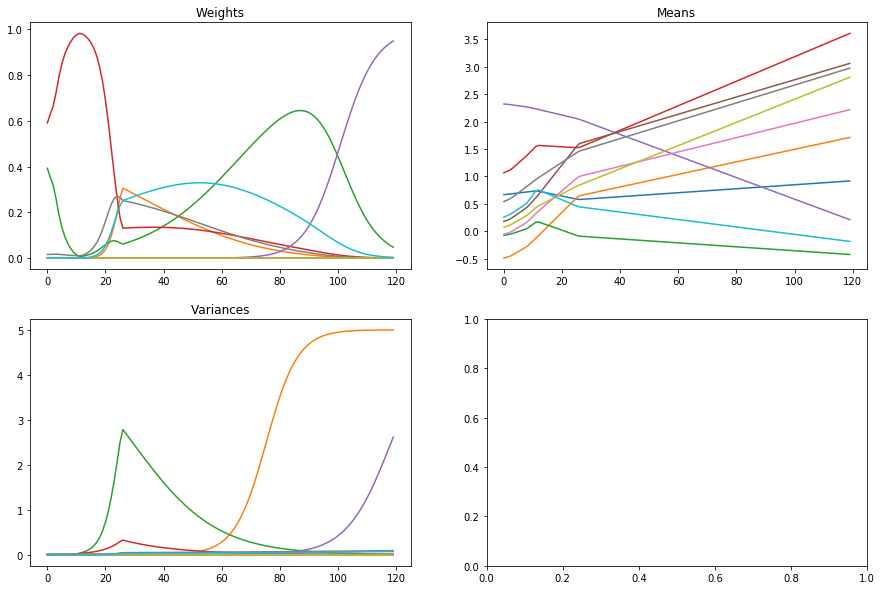

Epoch 18000
Loss 0.830803849374


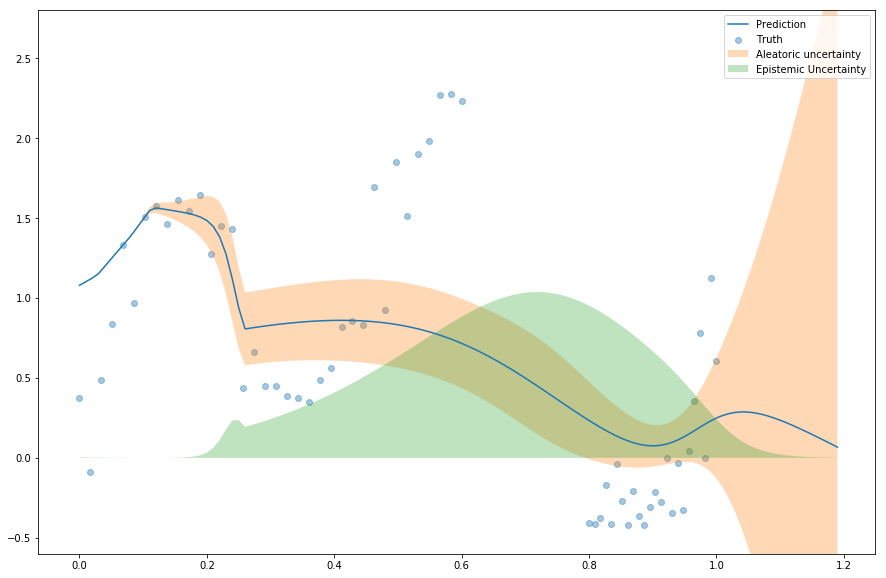

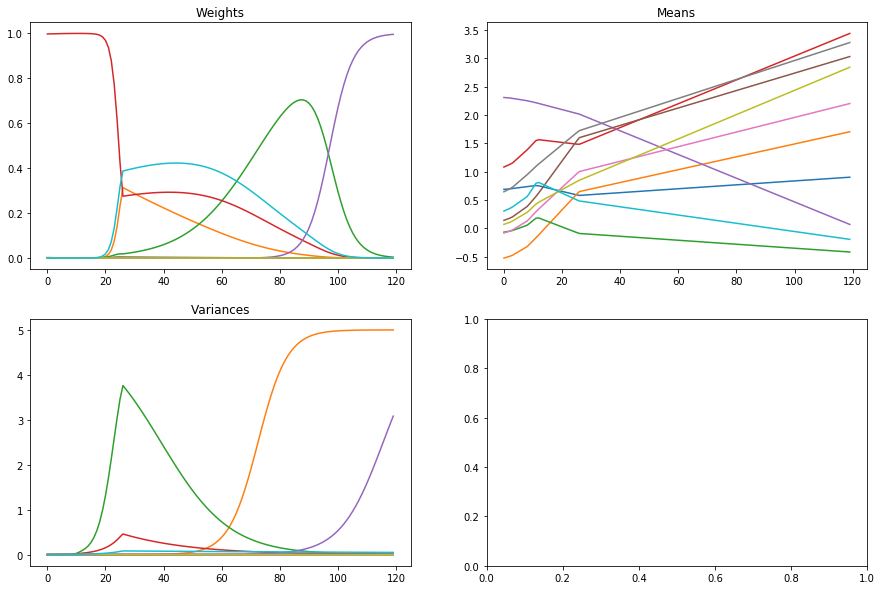

Epoch 20000
Loss 0.673072759885


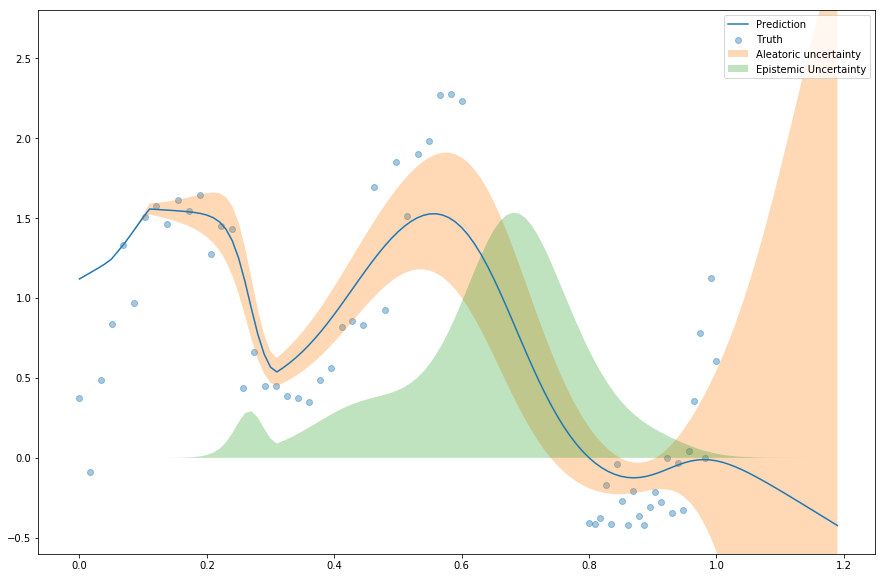

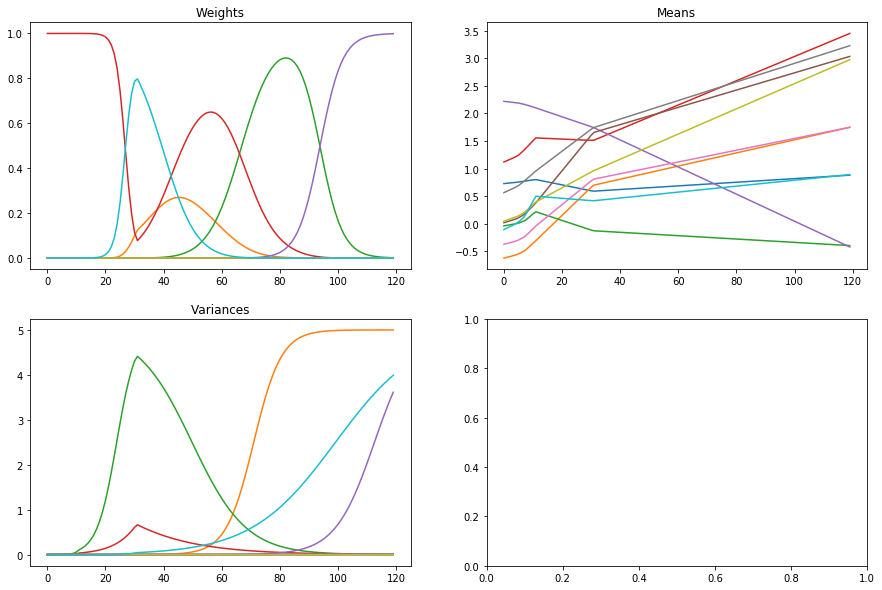

Epoch 22000
Loss 1.0937788841


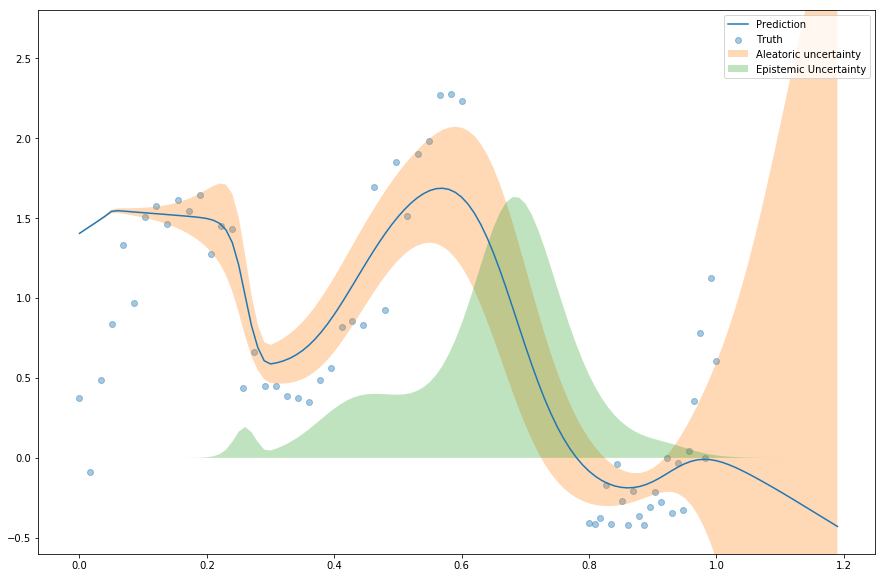

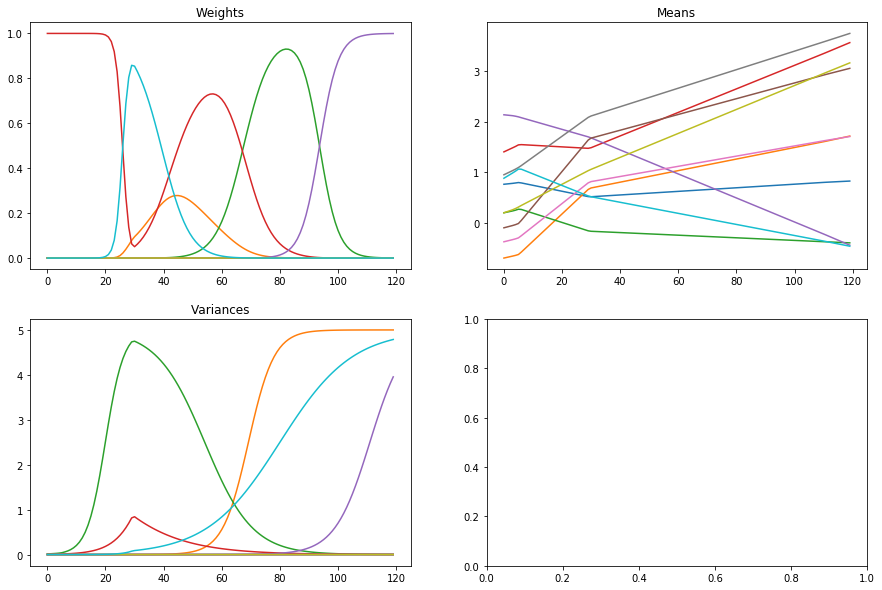

Epoch 24000
Loss 0.137948273941


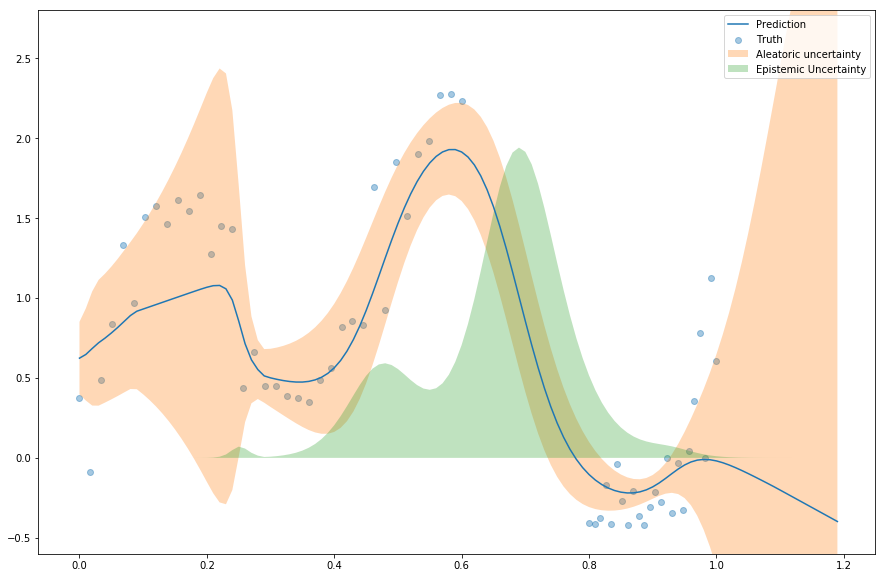

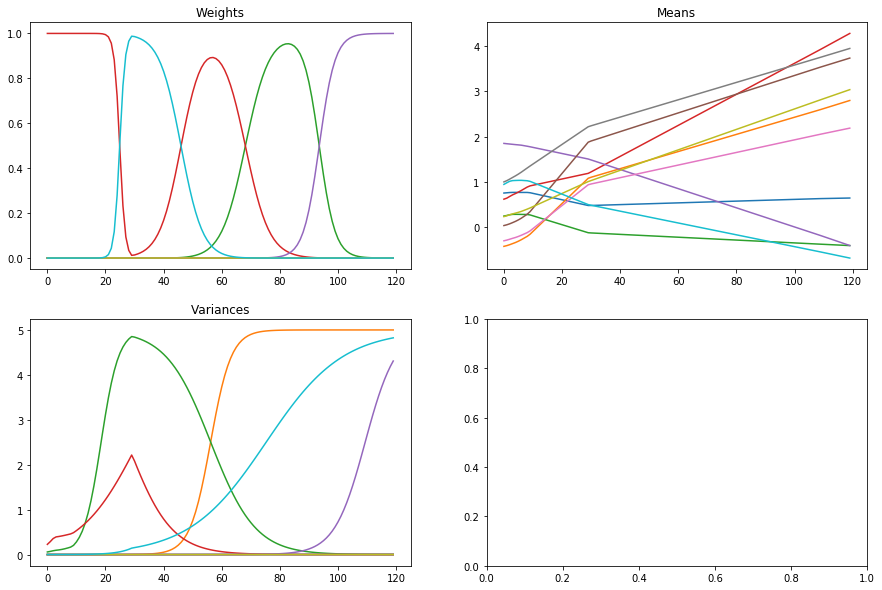

Epoch 26000
Loss 0.00461070902201


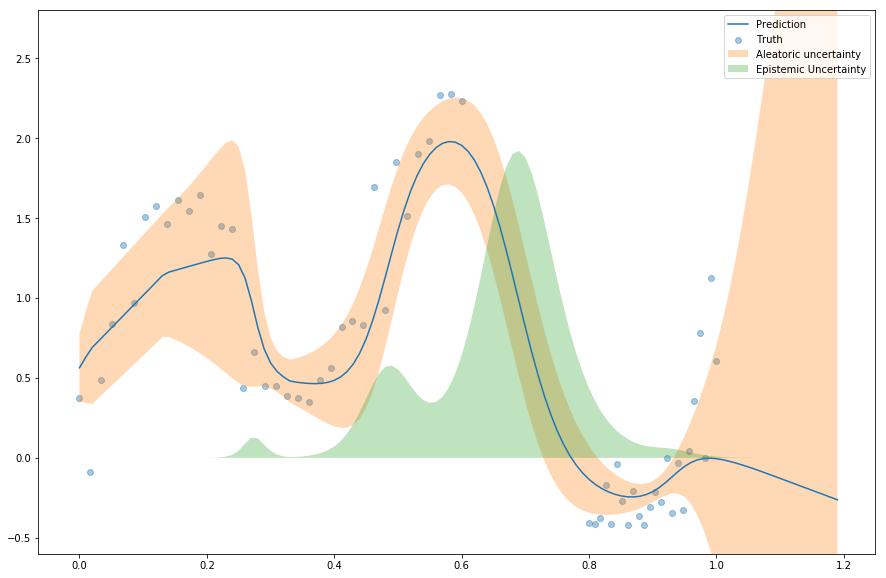

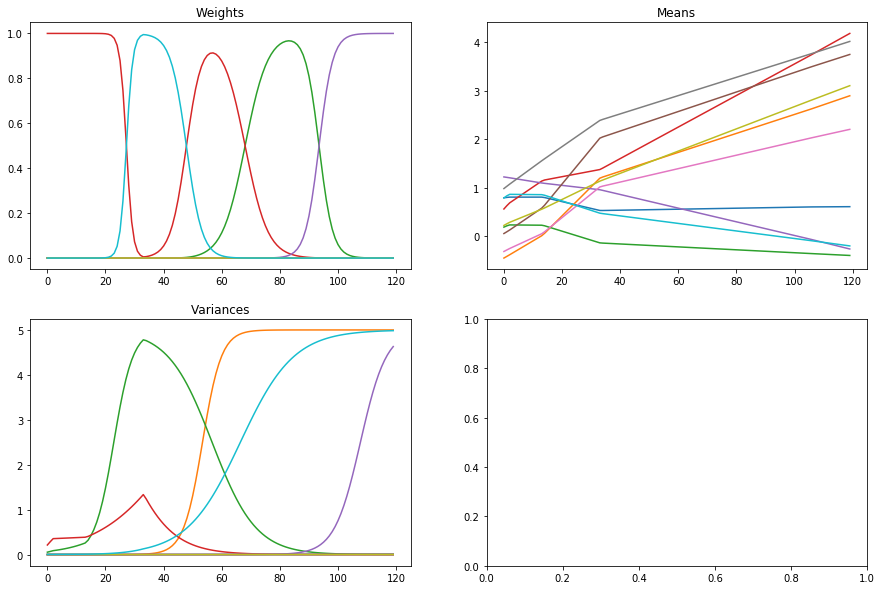

Epoch 28000
Loss -0.272013440874


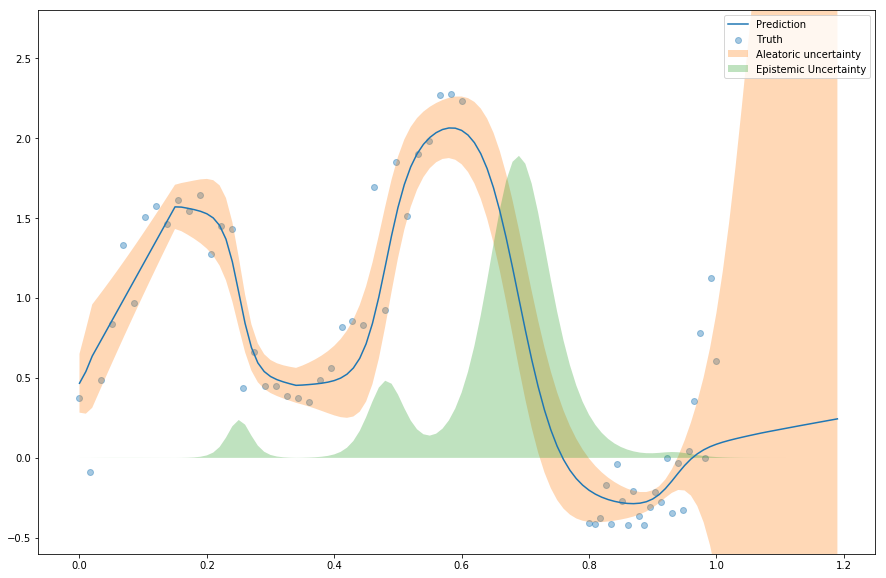

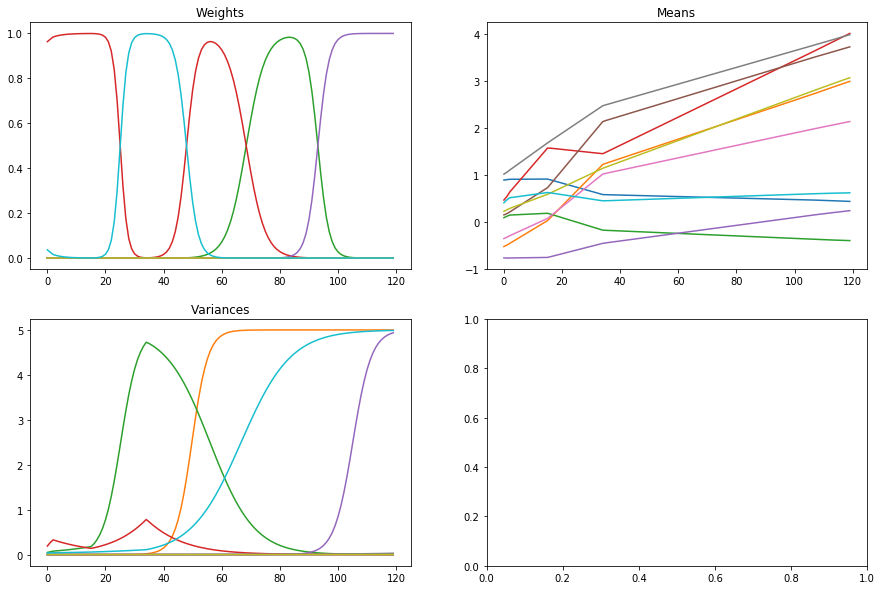

Epoch 30000
Loss -0.481359864823


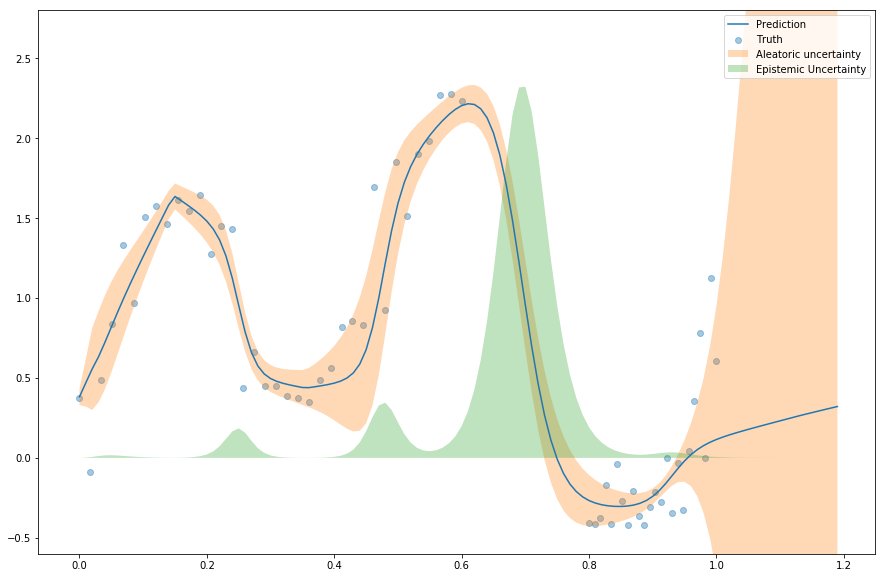

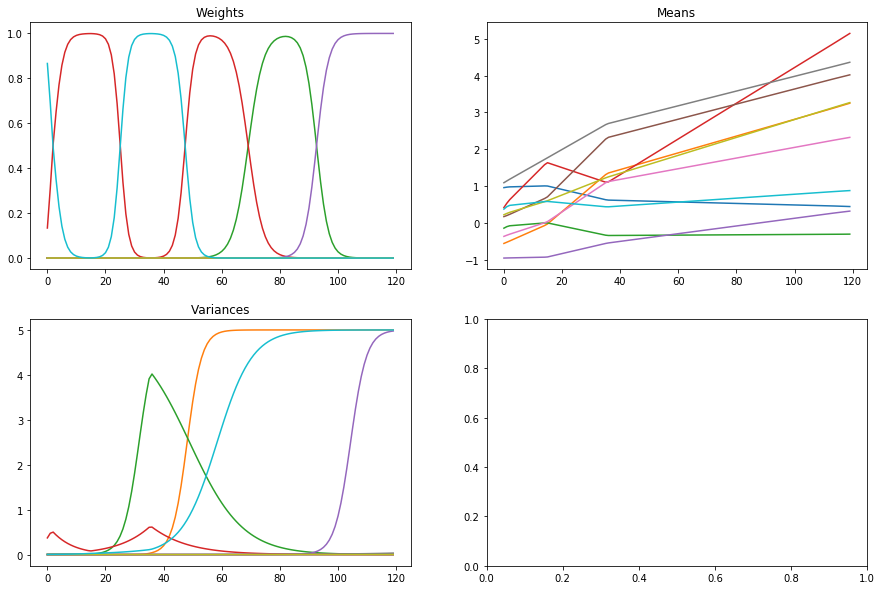

Epoch 32000
Loss -0.448871187362


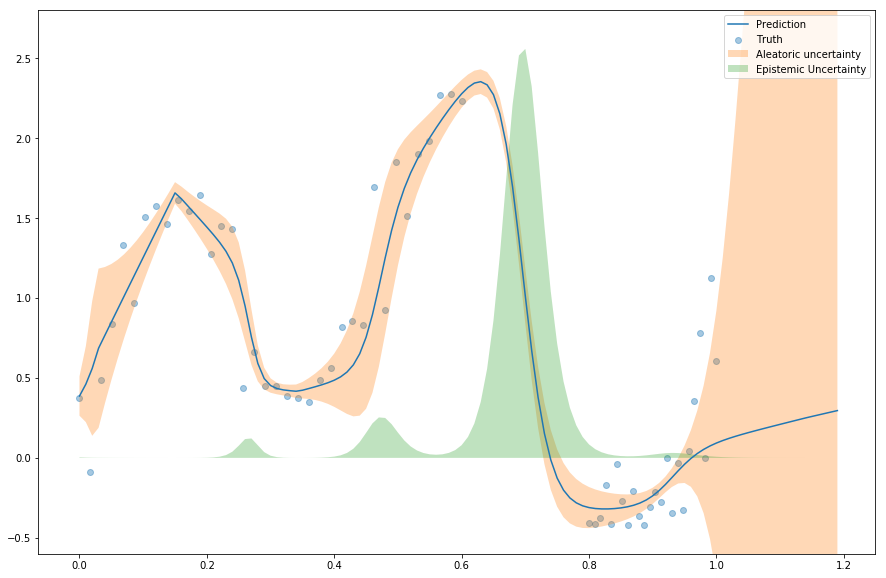

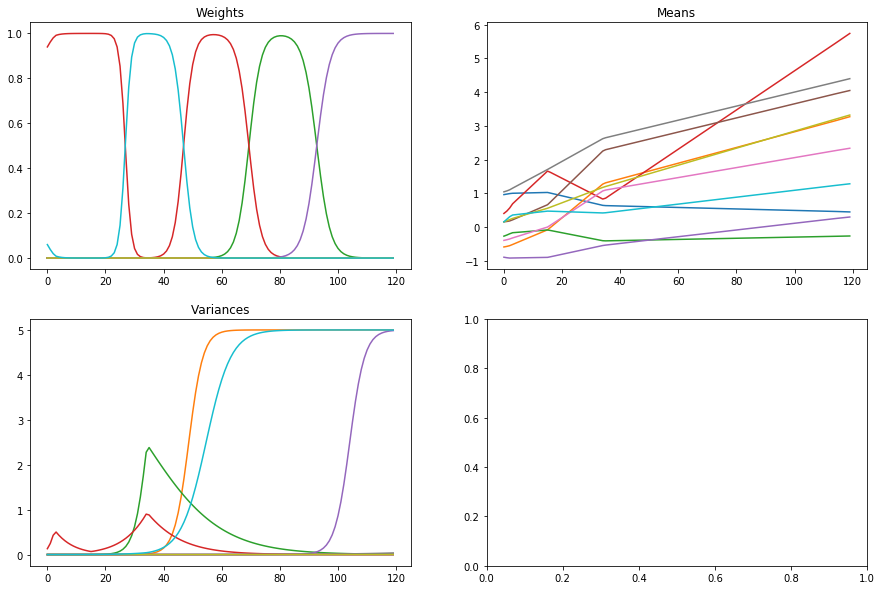

Epoch 34000
Loss -0.4978608764


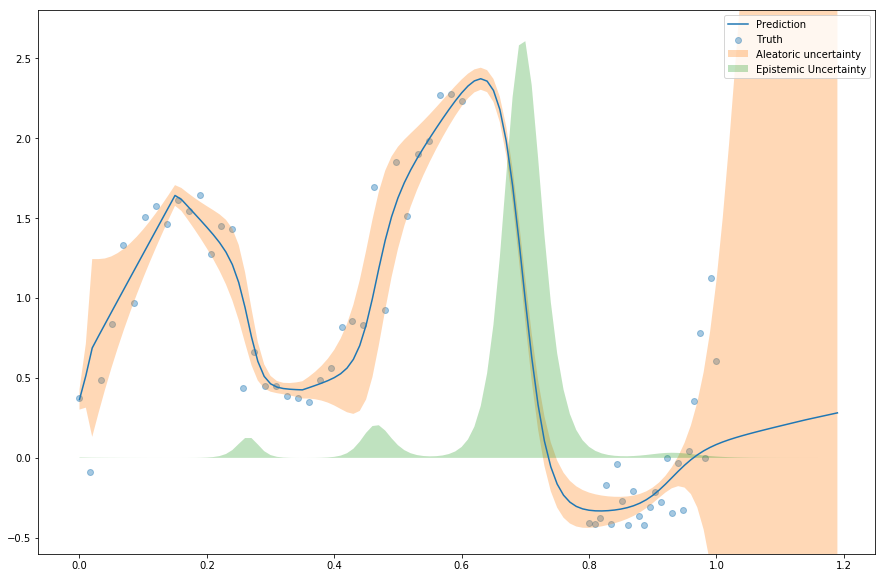

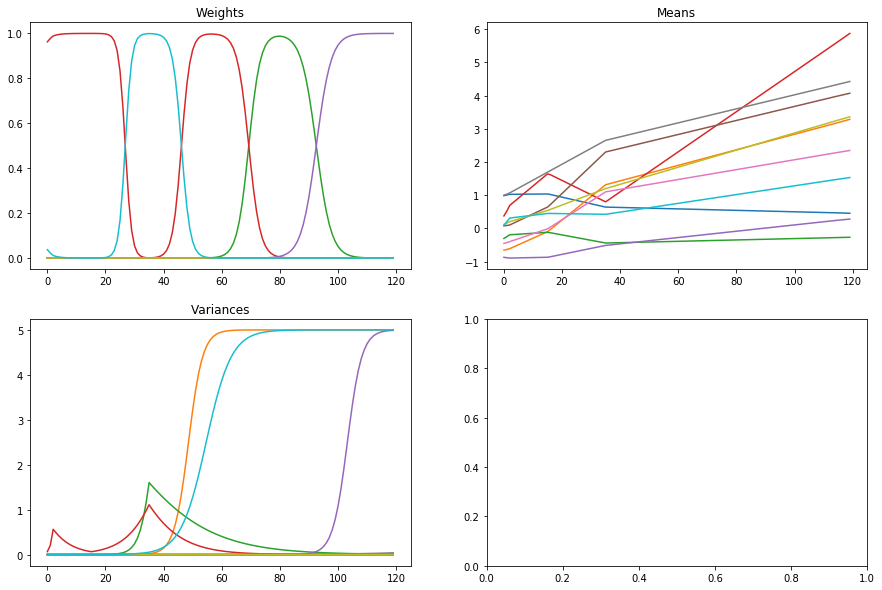

Epoch 36000
Loss -0.504228313049


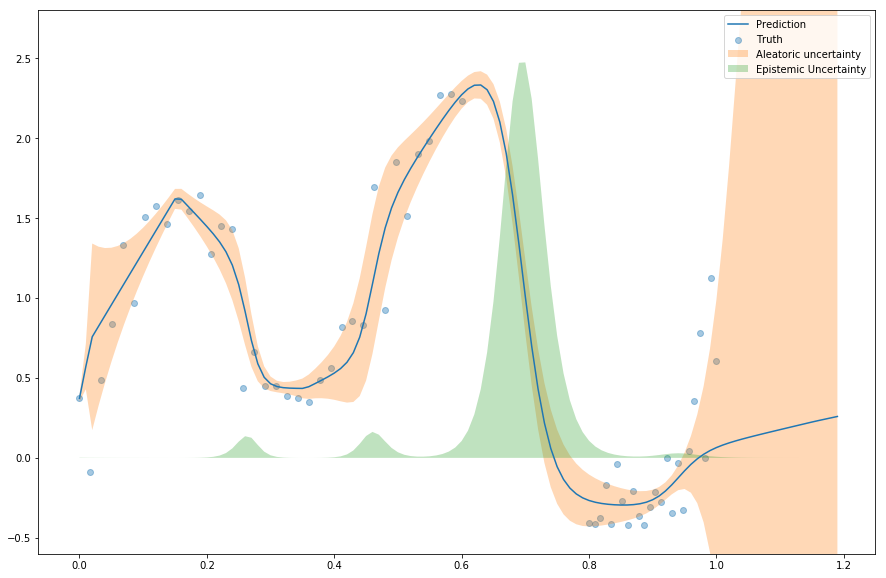

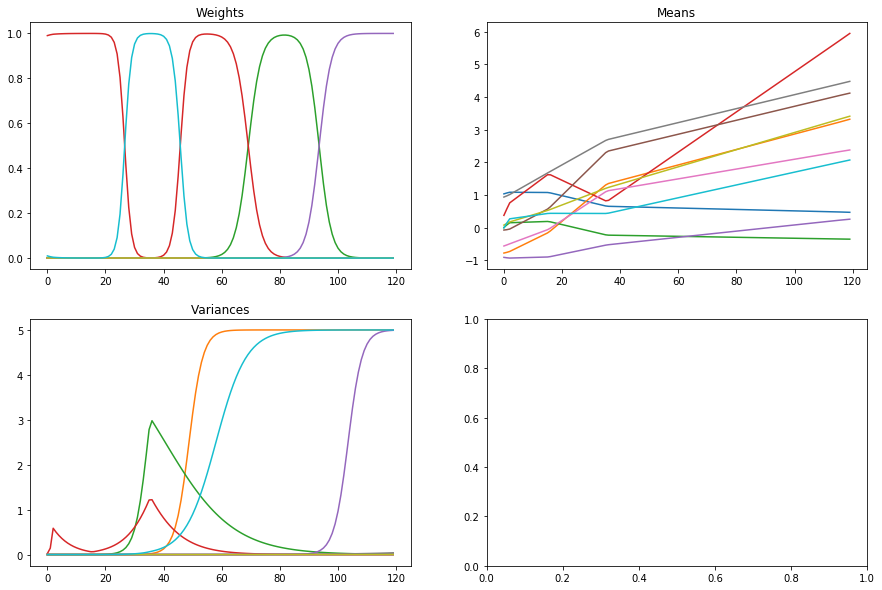

Epoch 38000
Loss -0.587442193951


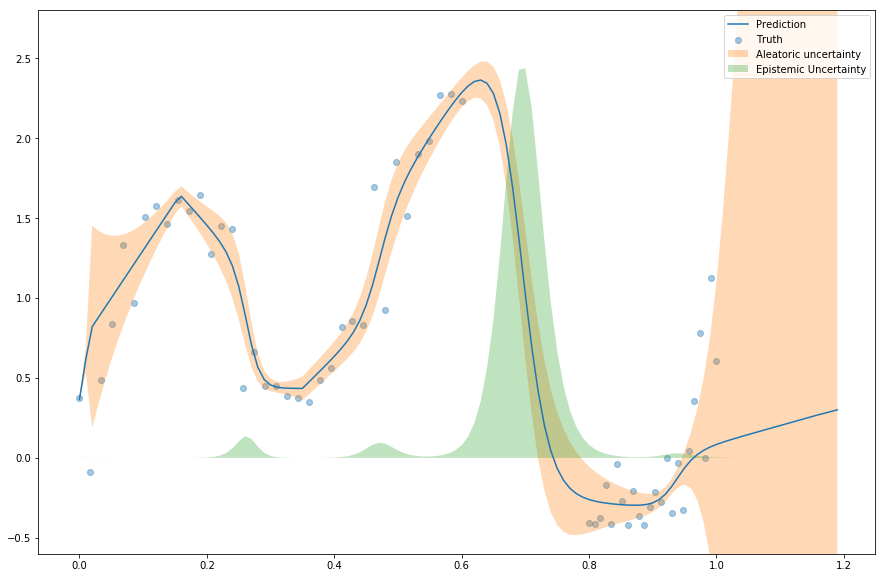

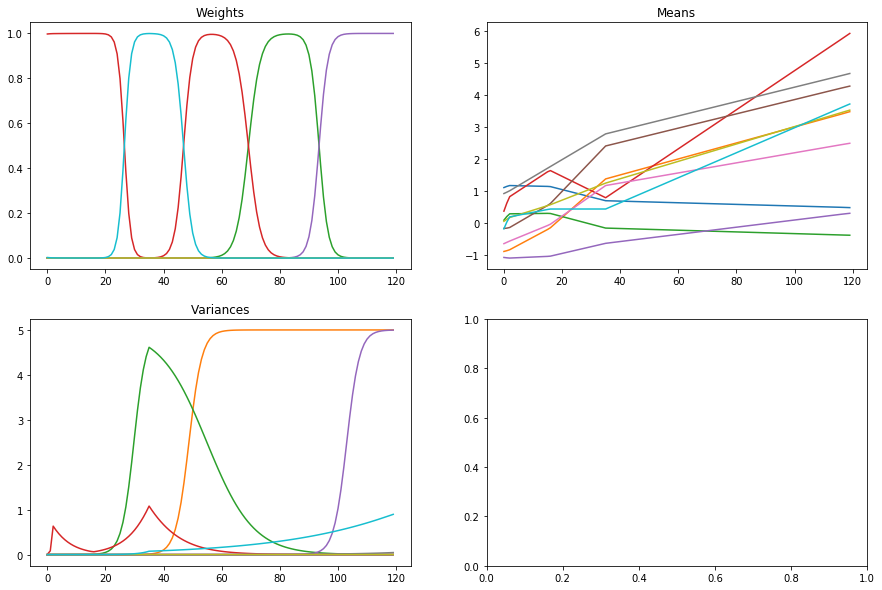

Epoch 40000
Loss -0.332559762503


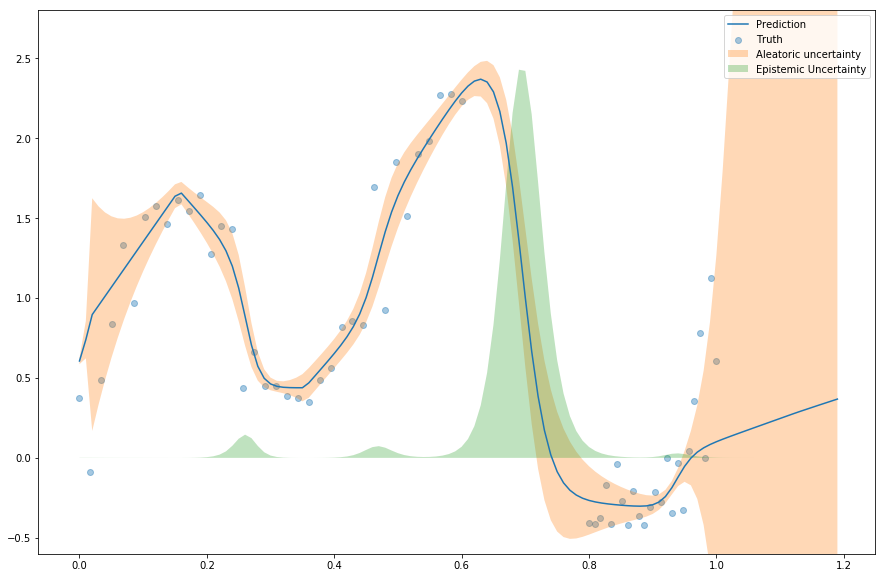

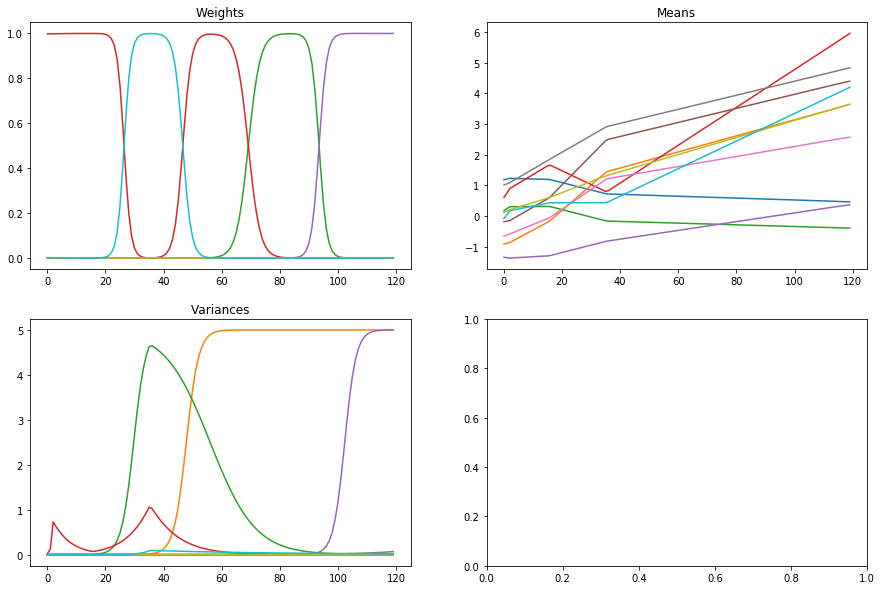

Epoch 42000
Loss -0.363161655483


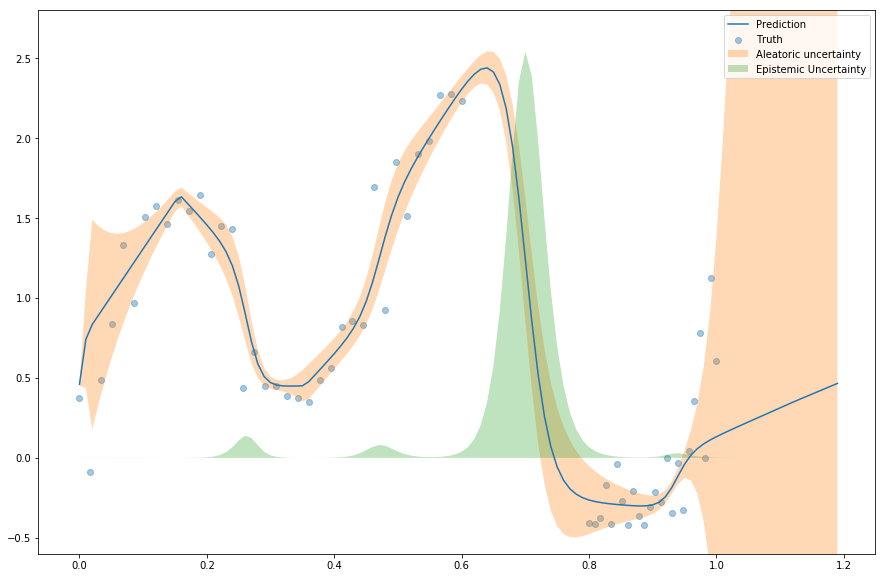

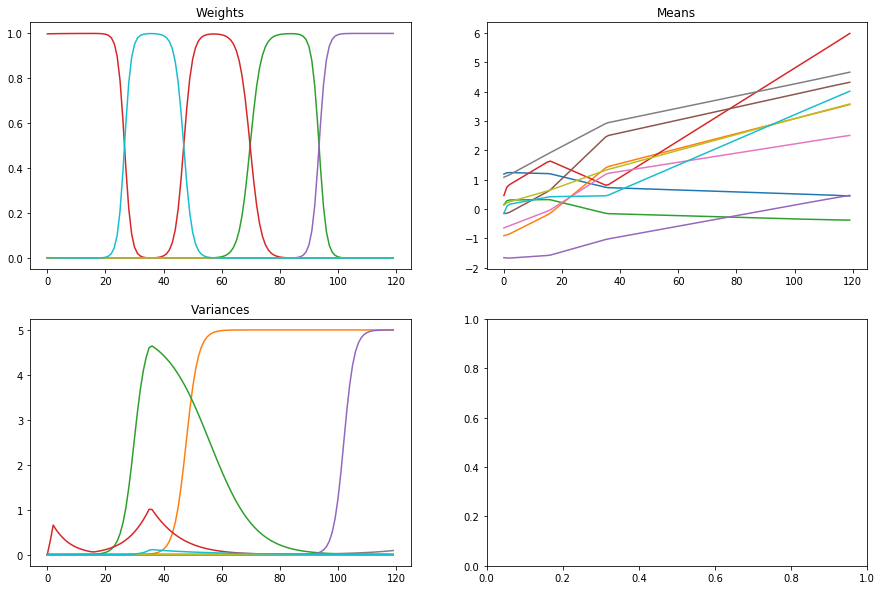

Epoch 44000
Loss -0.592734667162


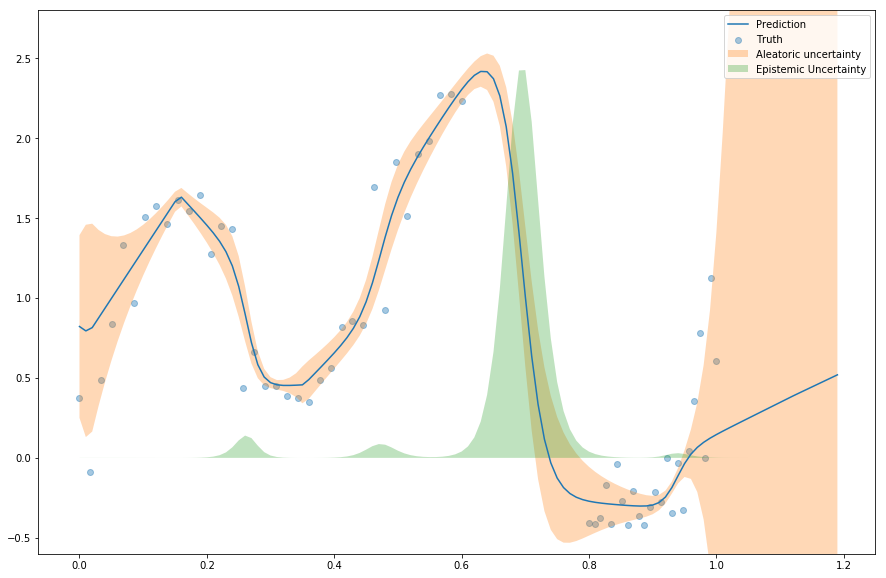

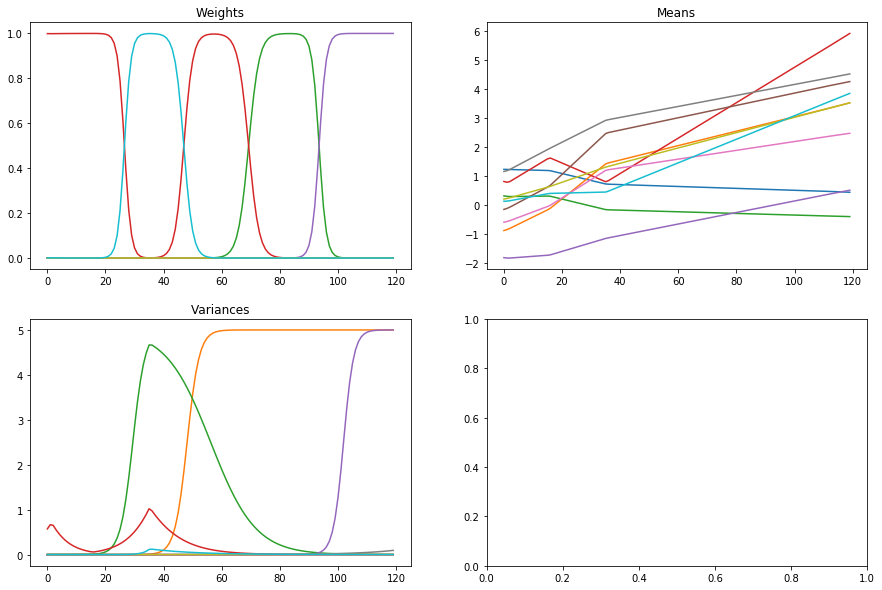

Epoch 46000
Loss -0.604830485283


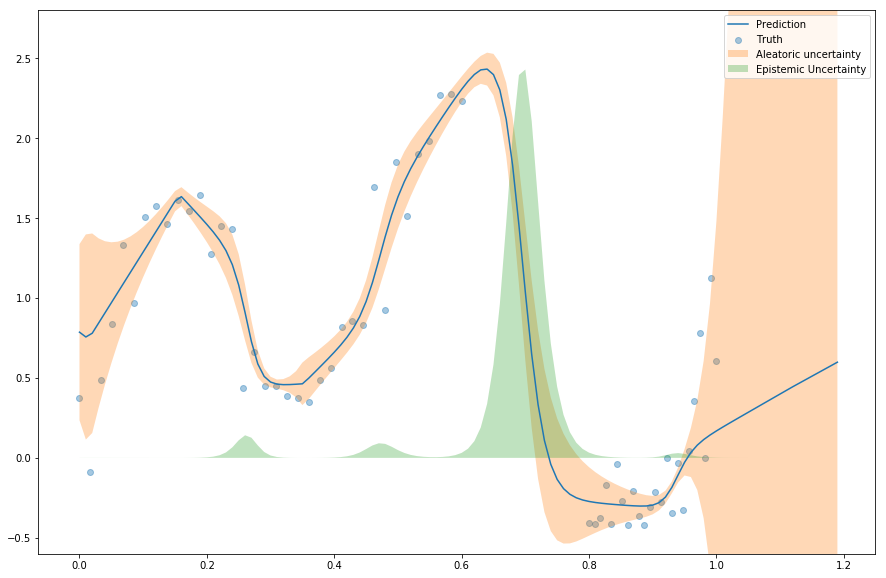

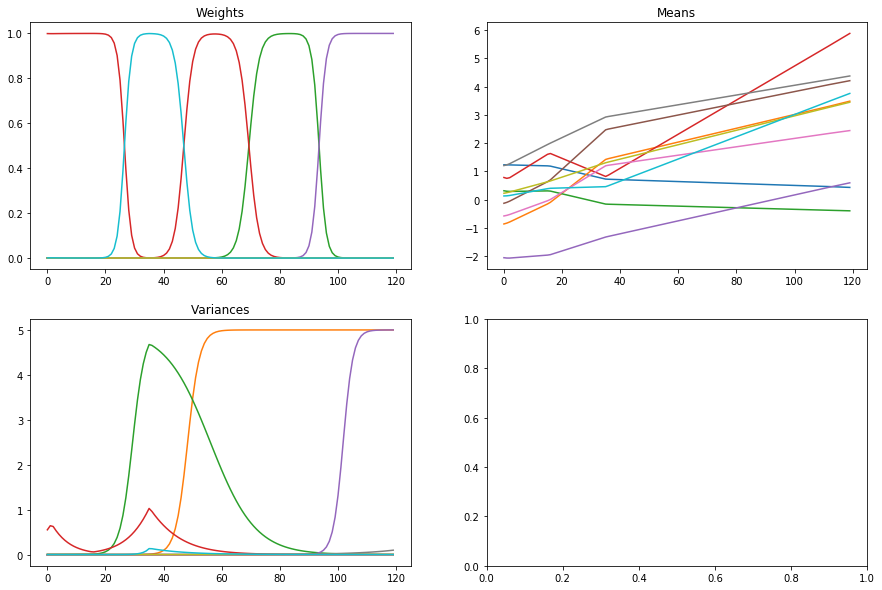

Epoch 48000
Loss -0.610698856106


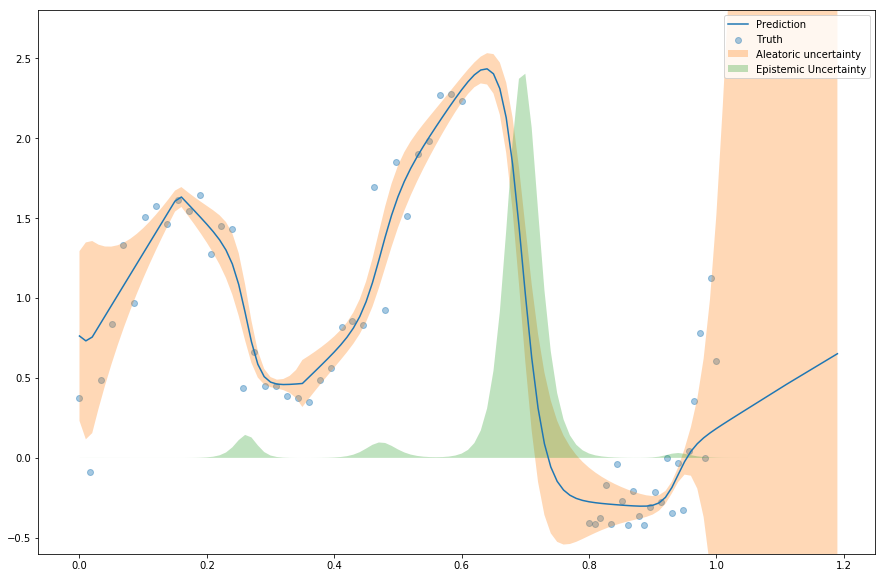

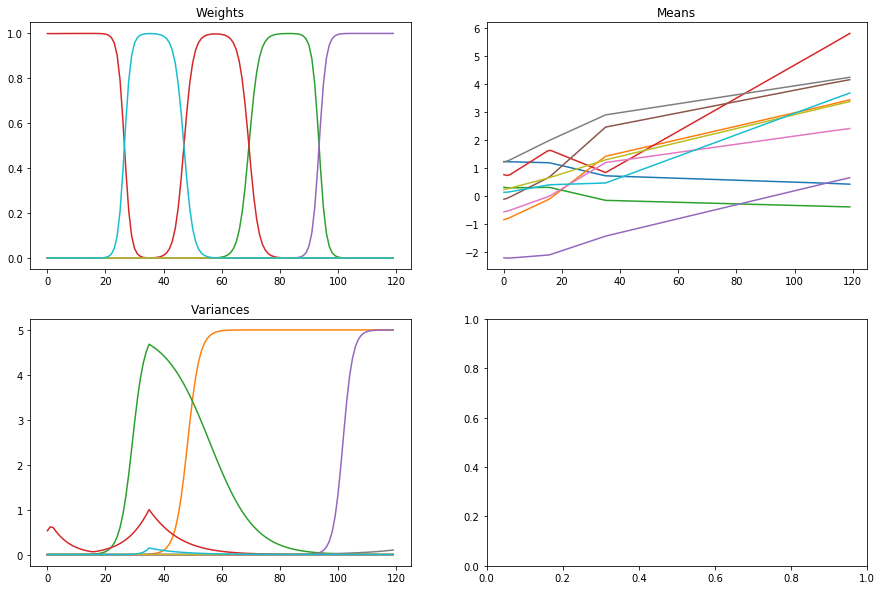

Training done


In [24]:
learning_rate = 0.001
display_step = 2000
eps = 1e-6

# each component has shape (?, n_mixtures)
mixture_weights, mixture_means, mixture_variances = mixture_density_network(x_data, n_mixtures=10)
optimizer = tf.train.AdamOptimizer(learning_rate)
dist = tf.distributions.Normal(loc=mixture_means, scale=mixture_variances)  #
loss = - tf.reduce_mean(
    tf.log(tf.reduce_sum(mixture_weights * dist.prob(y_data), axis=1) + eps),
    axis=0
) #+ 0.0001 * tf.reduce_sum(1 / (mixture_variances + 0.01))

train = optimizer.minimize(loss)

init = tf.global_variables_initializer()                                  
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

for epoch in range(50000):
    sess.run(train, feed_dict={x_data: x.reshape([-1, 1]),
                               y_data: y.reshape([-1, 1])})

    if (epoch % display_step == 0):
        print("Epoch {}".format(epoch))
        curLoss = sess.run(loss, feed_dict={x_data: x.reshape([-1, 1]),
                                            y_data: y.reshape([-1, 1])})  
        print("Loss {}".format(curLoss))
        print("================")
        plot_both()

print("Training done")

In [13]:
def plot():
    pred_range = np.arange(-0.2, 1.2, 0.01)
    pred_weights, pred_means, pred_variances = sess.run([mixture_weights, mixture_means, mixture_variances],
                      feed_dict={x_data: pred_range.reshape([-1, 1])})
    mean_y = np.sum(pred_weights * pred_means, axis=1)
    aleatoric_uncertainty = np.sum(pred_weights * pred_variances, axis=1)
    #epistemic_uncertainty = np.var(pred_weights * pred_means, axis=1)
    epistemic_uncertainty = np.sum(pred_weights * np.square(pred_means - np.expand_dims(np.sum(pred_weights * pred_means, axis=1),
                                                                                        axis=1)),
                                   axis=1)

    plt.figure(figsize=(15, 10))
    plt.plot(pred_range, mean_y, label="Prediction")
    plt.scatter(x, y, label="Truth", alpha=0.4)
    plt.fill_between(pred_range, mean_y - aleatoric_uncertainty, mean_y + aleatoric_uncertainty, alpha=0.3,
                     label="Aleatoric uncertainty")
    plt.fill_between(pred_range, 0, epistemic_uncertainty, alpha=0.3,
                     label="Epistemic Uncertainty")
    plt.ylim(-0.6, 2.8)
    plt.legend()
    plt.show()
    
def plot_both():
    pred_range = np.arange(-0.0, 1.2, 0.01)
    pred_weights, pred_means, pred_variances = sess.run([mixture_weights, mixture_means, mixture_variances],
                      feed_dict={x_data: pred_range.reshape([-1, 1])})
    
    mean_y = np.sum(pred_weights * pred_means, axis=1)
    aleatoric_uncertainty = np.sum(pred_weights * pred_variances, axis=1)
    #epistemic_uncertainty = np.var(pred_weights * pred_means, axis=1)
    epistemic_uncertainty = np.sum(pred_weights * np.square(pred_means - np.expand_dims(np.sum(pred_weights * pred_means, axis=1),
                                                                                        axis=1)),
                                   axis=1)

    plt.figure(figsize=(15, 10))
    plt.plot(pred_range, mean_y, label="Prediction")
    plt.scatter(x, y, label="Truth", alpha=0.4)
    plt.fill_between(pred_range, mean_y - aleatoric_uncertainty, mean_y + aleatoric_uncertainty, alpha=0.3,
                     label="Aleatoric uncertainty")
    plt.fill_between(pred_range, 0, epistemic_uncertainty, alpha=0.3,
                     label="Epistemic Uncertainty")
    plt.ylim(-0.6, 2.8)
    plt.legend()    
    
    f, axs = plt.subplots(2, 2, figsize=(15,10))
    axs[0,0].plot(pred_weights)
    axs[0,0].set_title("Weights")
    axs[0,1].plot(pred_means)
    axs[0,1].set_title("Means")
    axs[1,0].plot(pred_variances, label="Variance")
    axs[1,0].set_title("Variances")
    
    plt.show()

Text(0.5,1,u'Variances')

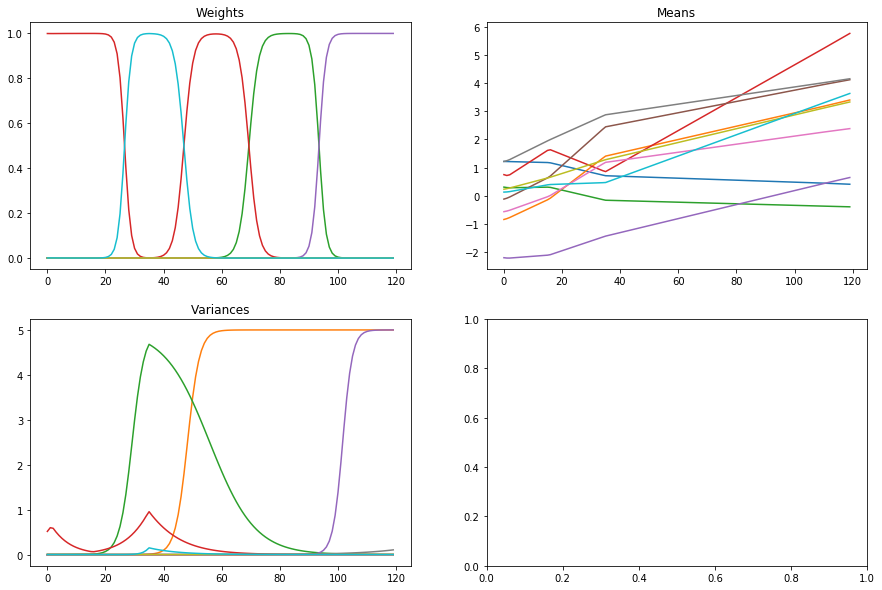

In [25]:
pred_range = np.arange(-0.0, 1.2, 0.01)
pred_weights, pred_means, pred_variances = sess.run([mixture_weights, mixture_means, mixture_variances],
                  feed_dict={x_data: pred_range.reshape([-1, 1])})
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs[0,0].plot(pred_weights)
axs[0,0].set_title("Weights")
axs[0,1].plot(pred_means)
axs[0,1].set_title("Means")
axs[1,0].plot(pred_variances, label="Variance")
axs[1,0].set_title("Variances")

In [ ]:
x, y = sample_generators.generate_osband_sin_samples(size=30, variance_1=0.03, variance_2=0.09)